# 3.6 Project F2: Make Accurate Measurements of Particle Masses

## 3.6.1 Goals of project
You will use LHCb data on the invariant mass of particle candidates that you were introduced
to during a checkpoint. You will analyse this in a much more sophisticated way, closer to the
actual analysis performed leading to its publication. You will use the maximum likelihood
process to fit different mass model shapes to the data. From this you will determine the
parameters of the mass model for the signal peaks, and their errors. You will start with a
very simple Gaussian mass model. You will then improve this and use a more sophisticated
model.
The projects have an open-ended aspect and are an opportunity where you can show your
own initiative and demonstrate your experimental and computational skills.
## 3.6.2 Equipment for project F2
This is a data handling exercise and the Raspberry Pi is not required, but can still be used.
You may find it faster to use the CPlab computers — there are several available in the DAH
laboratory. Alternatively you could use a personal laptop, but you will need to be able to
install Python and Python packages on your own.
## 3.6.3 Detailed project description
You were previously introduced to the LHCb Upsilon data. In this project you will explore
another LHCb dataset collected in 2011 where a pair of oppositely charged kaons and a pion
have been combined. Two clear peaks are observed in this mass spectrum corresponding
to the D+s (quark content cs) and D+ (quark content cd) mesons (charge conjugation is
implied), see figure below For more information see: DOI:10.1007/JHEP06(2013)065.

Download the files kkp.bin and kkpp.bin files from the DAH Dropbox, These files contain
the data recorded by LHCb in 2011 for D+
(s) and D0 decays respectively. Focus on the D+
(s)
data file (kkp.bin): The files are written in binary format and contain seven observables

• invariant mass of K+K−π+ candidate in MeV/c2

• invariant mass of kaon pair in MeV/c2

• transverse momentum of K+K−π+ candidate in GeV/c

• rapidity η of K+K−π+ candidate

• minimum tranverse momentum of the three tracks in the K+K−π+ candidate

• electric charge of the candidate

• polarity of the LHCb magnetic field

Write a Python script that reads the data from this file, see below.


In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import scipy.integrate as integrate
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from scipy.stats import crystalball

In [2]:
f = open("kkp.bin","r")
b = np.fromfile(f,dtype=np.float32)
ncol = 7
# number of events
nevent = len(b)/ncol
xdata = np.split(b, nevent, axis=0)
print(xdata[0])
# make list of invariant mass of events
xmass = []
for i in range(0, len(xdata)):
    xmass.append((xdata[i][0])/1000)
    if i < 10:
        print(xmass[i])
        

[ 2.0353304e+03  1.0168776e+03  7.0066626e+03  2.7526996e+00
  1.2672668e+03 -1.0000000e+00 -1.0000000e+00]
2.0353304443359375
1.97662109375
1.9516748046875
1.948279052734375
1.96346044921875
2.0428231201171876
1.974309814453125
1.963476318359375
1.9582470703125
1.954701904296875


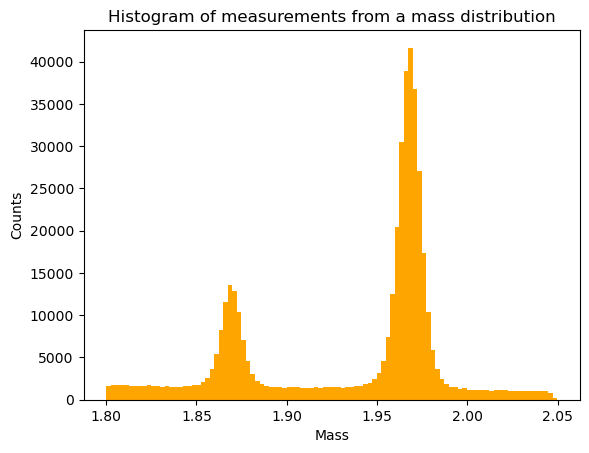

In [3]:
# Plotting as histogram to see the range of data
plt.hist(xmass, bins = 100, color='orange')
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

During checkpoint 6, you performed some very simple “peak finding.” In this project you
are going to do the analysis much like it would actually be carried out in a particle physics
experiment.

1. Consider first the D+ peak which is the particle with the lowest mass, i.e. the left
most peak in the plot. Construct a composite probability density function (PDF) for
the invariant mass of the muon pairs, which contains two components:<br>
• A Gaussian shape to fit the D+ mass peak;<br>
• A shallow falling exponential to fit the background shape of the mass spectrum<br>
underneath and around the peak.

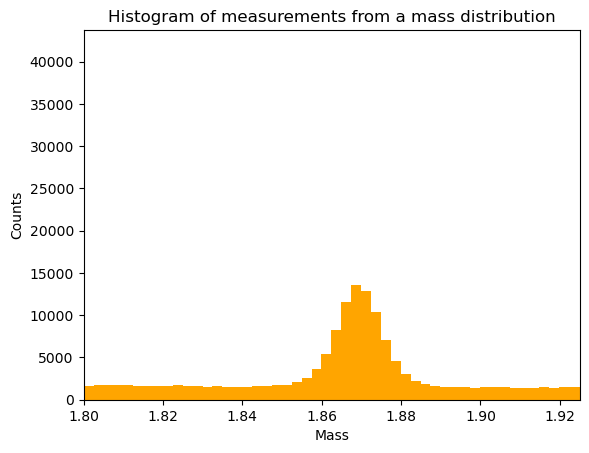

In [4]:
# Plotting as histogram to see the range of data
plt.hist(xmass, bins = 100, color='orange')
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.xlim([1.800, 1.925])
plt.show()

In [5]:
xmass_min=1.800
xmass_max=1.925

def norm_exp(x, tau):
    exp_norm_factor = np.exp(-xmass_min/tau) - np.exp(-xmass_max/tau)
            
    return ((1/(tau*exp_norm_factor))*np.exp(-x/tau))


def gauss(x, mu, sigma):         
    return np.exp(-0.5*((x-mu)/sigma)**2)


def norm_gauss(x, mu, sigma):
    
    #norm_gauss_factor, _ = integrate.quad(gauss, xmass_min, xmass_max, args = (mu, sigma))
    #norm_gauss = (1/norm_gauss_factor)*np.exp(-0.5*((x-mu)/sigma)**2)
    norm_gauss = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*(((x-mu)/sigma)**2))
    
    return norm_gauss


def composite_pdf(x, mu, sigma, tau, f):
    """
    Composite PDF.
        
    Args:

    """    
    return (f*norm_exp(x, tau) + (1-f)*norm_gauss(x, mu, sigma))

In [6]:
xmass = np.array(xmass)
xmass_dplus = xmass[(xmass <= xmass_max) & (xmass >= xmass_min)] 
xmass_dplus  = np.array(xmass_dplus)
print(len(xmass_dplus))

145710


In [7]:
# set guesses for minuit
mu_guess = 1.870
sigma_guess = 0.005
tau_guess = 0.9
f_guess = 0.6

In [8]:
weights= np.repeat((1/len(xmass_dplus)),100)
#print(weights)

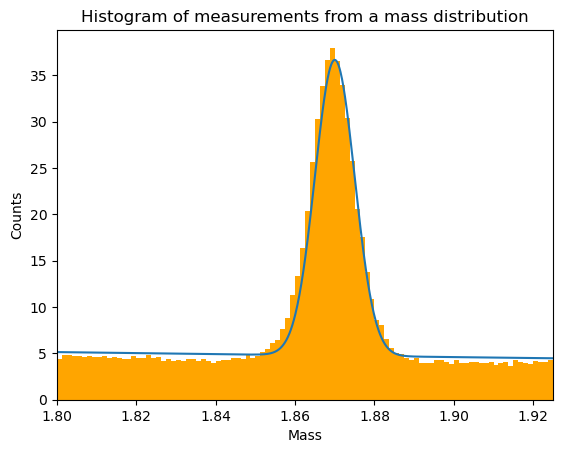

In [9]:
#RECENT COMMENT
#i realised that n depends on THE NUMBER OF BINS IN OUR HISTOGRAM
#if u change the number of bins in our histogram you need to change n for it to match
#number of bins is just a property of the histogram not the data, and if number of bins affects the 
#value n, how can we set it as a minuit parameter??
#I am not sure what to set it as? maybe there is some relation between number of bins in hisogram and n?
#i think maybe these are the type of questions we can ask the tutors?
#but so that we can get a bit further into the project ive just set n by eye for now
#although this becomes a problem in part 4 when we do residuals

# Plotting
x = np.linspace(xmass_min, xmass_max, 1000)
y = composite_pdf(x, mu = mu_guess, sigma = sigma_guess, tau = tau_guess, f = f_guess)

# Plotting as histogram to see the range of data
plt.hist(xmass_dplus, bins = 100, color='orange',density=True)
plt.plot(x, y)
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.xlim([1.800, 1.925])
plt.show()

2. Use this PDF in a Maximum Likelihood fit to determine the parameters of the PDF.
Note that it is essential that the composite PDF remains normalised to 1 over the
range of the fit.
Determine the D+ meson mass and yield, and all other parameters, and their errors.
You should be able to obtain the parameter errors directly from the minimization en-
gine of your choice (scipy.optimize.minimise, scipy.optimise.curve_fit, lmfit, see https:
//lmfit.github.io/lmfit-py/ or Minuit). Depending on your choice you will be able
to chose different minimising methods. It would be good to show that you understand
these by obtaining them yourself from the parameters of the Gaussian signal fit — this
is described in the data handling lectures.
Plot the fitted signal shape on top of the data.

In [10]:
#create a function for the NLL (for test)
def nll(mu,sigma,tau,f):
    array = [] 
    for i in range(len(xmass_dplus)):
        nll_1 = np.log(composite_pdf(xmass_dplus[i], mu , sigma , tau , f  ))
        array.append(nll_1)
    nll = -np.sum(array)
    
    return nll

In [11]:
#RECENT COMMENT
#The reason minuit was not working is because we set the initial error on tau to be 0.1, this is bigger 
#than out actual "starting value" of tau. The inital error was basically too large for minuit to work
#so i chamged it to 0.001

nll = UnbinnedNLL(xmass_dplus, composite_pdf)
# set params to some vals
minuit = Minuit(nll, mu = mu_guess, sigma = sigma_guess, tau = tau_guess, f = f_guess)
minuit.errordef = 0.5
minuit.errors = [0.1, 0.001, 0.1, 0.1]
minuit.limits["f"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")
          

mu = 1.8694306920463313 +/- 1.9863932920991584e-05
sigma = 0.00566498683144171 +/- 1.8496606601244364e-05
tau = 0.8712830316372869 +/- 0.05394096212747999
f = 0.5414083225102159 +/- 0.001245870550840189


In [12]:
#create a function for the NLL (for test)
def nll(mu,sigma,tau,f,mass):
    array = [] 
    for i in range(len(xmass_dplus)):
        nll_1 = np.log(composite_pdf(mass[i], mu , sigma , tau , f  ))
        array.append(nll_1)
    nll = -np.sum(array)
    
    return nll

print("nll value:",nll(mu = minuit.values["mu"], sigma = minuit.values["sigma"], tau = minuit.values["tau"],f = minuit.values["f"], mass = xmass_dplus))

nll value: -356258.54843149515


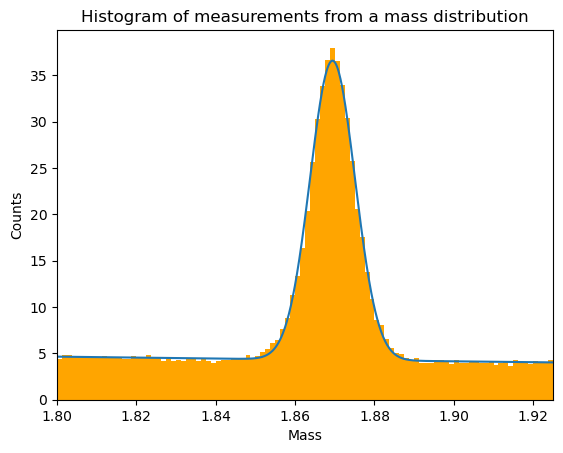

In [13]:
# Plotting
x = np.linspace(xmass_min, xmass_max, 1000)
y = composite_pdf(x, mu = minuit.values["mu"], sigma = minuit.values["sigma"], tau = minuit.values["tau"], f = minuit.values["f"])

# Plotting as histogram to see the range of data
plt.hist(xmass_dplus, bins = 100, color='orange',density=True)
plt.plot(x, y)
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.xlim([1.800, 1.925])
plt.show()

3. Now consider the entire mass range, and perform a simultaneous fit for both peaks,
and the underlying background. Again you should always report the parameter values,
and their errors. Plot the fitted signal shape on top of the data.

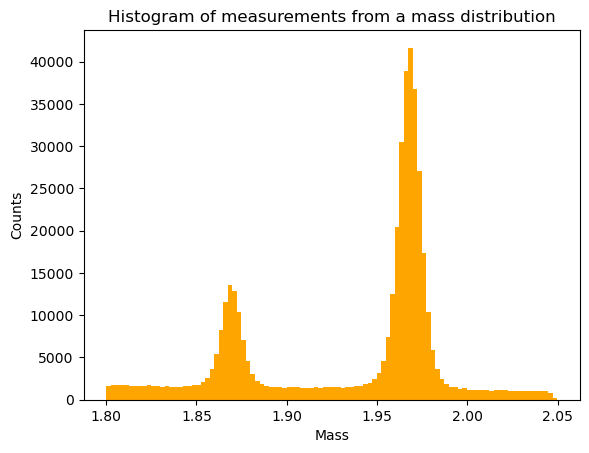

In [14]:
# Plotting as histogram to see the range of data
plt.hist(xmass, bins = 100, color='orange')
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

In [15]:
#define new max and min
xmass_min=1.800
xmass_max=2.05

def norm_gauss_2(x, mu_2, sigma_2):
    
    #norm_gauss_factor, _ = integrate.quad(gauss, xmass_min, xmass_max, args = (mu, sigma))
    #norm_gauss = (1/norm_gauss_factor)*np.exp(-0.5*((x-mu)/sigma)**2)
    norm_gauss = (1/(sigma_2*np.sqrt(2*np.pi)))*np.exp(-0.5*(((x-mu_2)/sigma_2)**2))
    
    return norm_gauss


def composite_pdf_2(x, mu, sigma, mu_2, sigma_2, tau, f,f_2):
    """
    Composite PDF.
        
    Args:

    """    
    return ( (f)*norm_gauss(x, mu, sigma) + (f_2)*norm_gauss_2(x, mu_2, sigma_2) + (1-(f_2+f))*norm_exp(x, tau))

In [16]:
# set guesses for minuit
mu_guess = 1.870
mu_2_guess = 1.97
sigma_guess = 0.005
sigma_2_guess = 0.005
tau_guess = 0.9
f_guess = 0.2
f_2_guess = 0.5

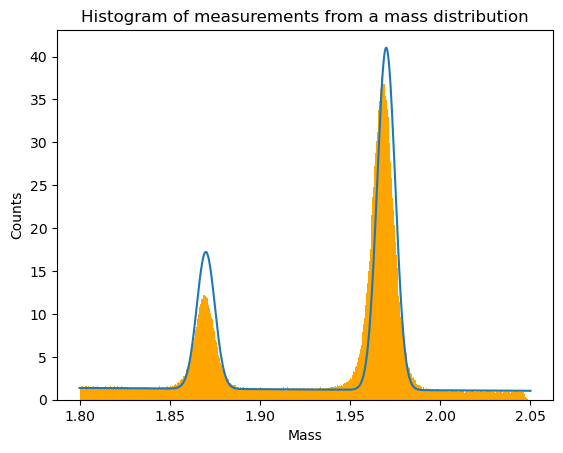

In [17]:
n_bins = 500
# Plotting
x = np.linspace(xmass_min, xmass_max, 1000)
y = composite_pdf_2(x, mu = mu_guess, sigma = sigma_guess, mu_2 = mu_2_guess, sigma_2 = sigma_2_guess, tau = tau_guess, f = f_guess, f_2 = f_2_guess)

# Plotting as histogram to see the range of data
plt.hist(xmass, bins = n_bins , color='orange',density=True)
plt.plot(x, y)
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()


In [18]:
nll = UnbinnedNLL(xmass, composite_pdf_2)
# set params to some vals
minuit = Minuit(nll, mu = mu_guess, sigma = sigma_guess, mu_2 = mu_2_guess, sigma_2 = sigma_2_guess, tau = tau_guess, f = f_guess, f_2 = f_2_guess)
minuit.errordef = 0.5
minuit.errors = [0.1, 0.001, 0.1, 0.001,0.1,0.1,0.1]
minuit.limits["f"] = (0, 1)
minuit.limits["f_2"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")

mu = 1.8694475972929228 +/- 1.9812049280204076e-05
sigma = 0.00564233031049897 +/- 1.8208850593506714e-05
mu_2 = 1.9681006699227075 +/- 1.01000048366768e-05
sigma_2 = 0.006313411076410316 +/- 8.73646020557425e-06
tau = 0.5103825916740516 +/- 0.007349180269736438
f = 0.1467222795731773 +/- 0.0004522331404466229
f_2 = 0.5369237511849335 +/- 0.0005878687129611815


In [19]:
#create a function for the NLL (for test)
def nll(mass, mu, sigma, mu_2, sigma_2,tau,f,f_2):
    array = [] 
    for i in range(len(mass)):
        nll_1 = np.log(composite_pdf_2(mass[i], mu , sigma , mu_2 , sigma_2 ,tau , f ,f_2 ) )
        array.append(nll_1)
    nll = -np.sum(array)
    
    return nll

print("nll value for gassian and exponential:",nll(mass = xmass, mu = minuit.values["mu"], sigma = minuit.values["sigma"], mu_2 = minuit.values["mu_2"], sigma_2 = minuit.values["sigma_2"],tau = minuit.values["tau"], f = minuit.values["f"],f_2 = minuit.values["f_2"]))

nll value for gassian and exponential: -999211.8337993952


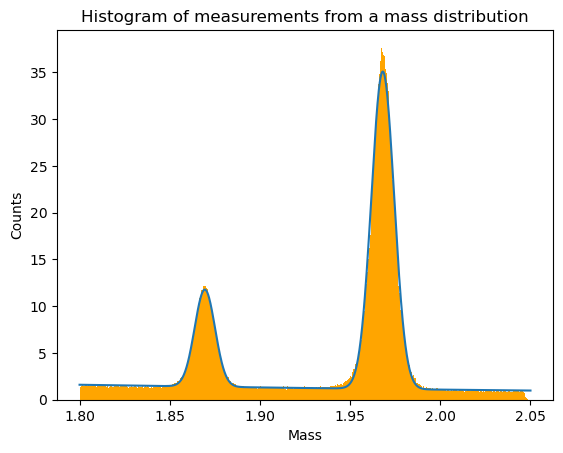

In [20]:
# Plotting
x = np.linspace(xmass_min, xmass_max, 1000)
y = composite_pdf_2(x, mu = minuit.values["mu"], sigma = minuit.values["sigma"], mu_2 = minuit.values["mu_2"], sigma_2 = minuit.values["sigma_2"],tau = minuit.values["tau"], f = minuit.values["f"],f_2 = minuit.values["f_2"])

# Plotting as histogram to see the range of data
counts = plt.hist(xmass, bins = n_bins, color='orange',density=True)
plt.plot(x, y)
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

4. The results so far probably look quite good by eye, i.e. the signal shape plotted on
top of the data probably looks like it fits well. However this can be misleading when
performing a precision measurement. You should make a plot of what are called the
“residuals.” A residual is the difference between the data in the binned histogram and
the best-fit mass model value for the centre of that bin. Describe what you see.

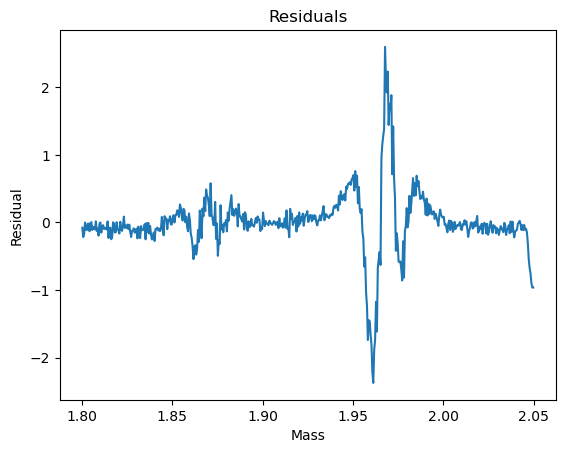

In [21]:
#resituals plot 
#i add 0.00025 because its centre of bin
x = np.linspace(1.8+0.00025,2.05-0.00025,500)
#print(x)
y = composite_pdf_2(x, mu = minuit.values["mu"], sigma = minuit.values["sigma"], mu_2 = minuit.values["mu_2"], sigma_2 = minuit.values["sigma_2"],tau = minuit.values["tau"], f = minuit.values["f"],f_2 = minuit.values["f_2"])
y = np.array(y)
#print(y)
#print(y.shape)

#counts = plt.hist(xmass, bins = n_bins, color='orange')
#counts = np.array(counts)

#print(counts)
#print(counts.shape)

residual = np.subtract(counts[0],y)
#print(residual)


plt.plot(x,residual)
plt.title('Residuals')
plt.ylabel('Residual')
plt.xlabel("Mass")
plt.show()


5. There are several ways to enhance the scope of the project. <br>
• If the single Gaussian mass model does not fit the data perfectly, one can try
other mass models, i.e. a signal PDF that goes beyond a single Gaussian func-
tion. One example is a PDF comprising a function which is the sum of two
Gaussian functions (i.e. one narrow and one wide Gaussian function to fit a sin-
gle D meson peak). Alternatively try a Crystal Ball function, which incorporates
a non-Gaussian tail at the lower end of the mass peak. The functional shape is de-
scribed elsewhere, e.g. see: https://en.wikipedia.org/wiki/Crystal_Ball_
function. You could implement each of these functions in your PDF and see how
much better they are at describing the data.<br>
• Read the publication and see what is said about systematic errors. Make a rea-
sonable attempt at determining some systematic errors on the masses.<br>
• Compare your results to the PDG and previous measurements.<br>
• Study how the mass and the width of the peak (the resolution) depends on the
transverse momentum (p⊥) and rapidity (η).

In [22]:
#### the sum of two Gaussian functions

#define new max and min
xmass_min=1.800
xmass_max=2.05

def norm_2gauss_summed(x, mu_1, sigma_1, mu_2, sigma_2):
    
    norm_factor = (sigma_1 + sigma_2)*np.sqrt(2*np.pi)
    norm_gauss = (1/(norm_factor))*(np.exp(-0.5*(((x-mu_1)/sigma_1)**2)) + np.exp(-0.5*(((x-mu_2)/sigma_2)**2)))
    
    return norm_gauss


def composite_pdf_summed(x, mu_1, sigma_1, mu_2, sigma_2, mu_3, sigma_3, mu_4, sigma_4, tau, f, f_1):
   
    return ((f)*norm_2gauss_summed(x, mu_1, sigma_1, mu_2, sigma_2) + (f_1)*norm_2gauss_summed(x, mu_3, sigma_3, mu_4, sigma_4) + (1-(f+f_1))*norm_exp(x, tau))

In [23]:
# set guesses for minuit
mu_1_guess = 1.87
sigma_1_guess = 0.004
mu_2_guess = 1.87
sigma_2_guess = 0.007
mu_3_guess = 1.97
sigma_3_guess = 0.004
mu_4_guess = 1.97
sigma_4_guess = 0.007
tau_guess = 0.5
f_guess = 0.15
f_1_guess = 0.5

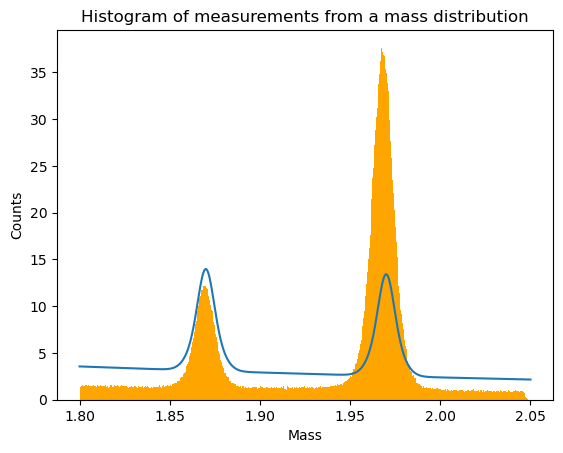

In [24]:
n_bins = 500
# Plotting
x = np.linspace(xmass_min, xmass_max, 1000)
y = composite_pdf_summed(x, mu_1=mu_1_guess, sigma_1=sigma_1_guess, mu_2=mu_2_guess, sigma_2=sigma_2_guess, mu_3 = mu_3_guess, sigma_3=sigma_3_guess, mu_4=mu_4_guess, sigma_4=sigma_4_guess, tau=tau_guess, f=f_guess, f_1=f_guess)

# Plotting as histogram to see the range of data
plt.hist(xmass, bins = n_bins , color='orange', density=True)
plt.plot(x, y)
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

In [25]:
nll = UnbinnedNLL(xmass, composite_pdf_summed)
# set params to some vals
minuit = Minuit(nll,mu_1=mu_1_guess, 
                sigma_1=sigma_1_guess, 
                mu_2=mu_2_guess, 
                sigma_2=sigma_2_guess, 
                mu_3 = mu_3_guess, 
                sigma_3=sigma_3_guess, 
                mu_4=mu_4_guess, 
                sigma_4=sigma_4_guess, 
                tau=tau_guess, 
                f=f_guess, 
                f_1=f_guess)

minuit.errordef = 0.5
minuit.errors = [0.1, 0.001, 0.1, 0.001, 0.1, 0.001, 0.1, 0.001, 0.1,0.1,0.1]
minuit.limits["f"] = (0, 1)
minuit.limits["f_1"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")

mu_1 = 1.8693876901577027 +/- 5.8406941979230616e-05
sigma_1 = 0.004203368537386629 +/- 4.8893304948195006e-05
mu_2 = 1.8695023860962896 +/- 5.726998903090096e-05
sigma_2 = 0.006830272438782642 +/- 3.577152322933678e-05
mu_3 = 1.9682971909605536 +/- 2.601827450328881e-05
sigma_3 = 0.004371582285643363 +/- 2.181497950311396e-05
mu_4 = 1.9679346071117734 +/- 2.3028656591345683e-05
sigma_4 = 0.007619395860545327 +/- 1.3917138678817794e-05
tau = 0.47484799485524554 +/- 0.0065634077378618925
f = 0.14964415130813719 +/- 0.00047108889605820825
f_1 = 0.5440617562766962 +/- 0.0005959231267874676


In [26]:
#create a function for the NLL (for test)
def nll(mass,mu_1 , sigma_1 , mu_2 , sigma_2 ,mu_3 , sigma_3 ,mu_4,sigma_4,tau,f,f_1):
    array = [] 
    for i in range(len(mass)):
        nll_1 = np.log(composite_pdf_summed(mass[i], mu_1 , sigma_1 , mu_2 , sigma_2 ,mu_3 , sigma_3 ,mu_4,sigma_4,tau,f,f_1 ) )
        array.append(nll_1)
    nll = -np.sum(array)
    
    return nll

print("nll value for sum of 2 gaussians:",nll(mass = xmass, mu_1 = minuit.values["mu_1"], sigma_1 = minuit.values["sigma_1"], mu_2 = minuit.values["mu_2"], sigma_2 = minuit.values["sigma_2"], mu_3 = minuit.values["mu_3"], sigma_3 = minuit.values["sigma_3"], mu_4 = minuit.values["mu_4"], sigma_4 = minuit.values["sigma_4"], tau = minuit.values["tau"], f = minuit.values["f"],f_1 = minuit.values["f_1"]))

nll value for sum of 2 gaussians: -1000161.953932055


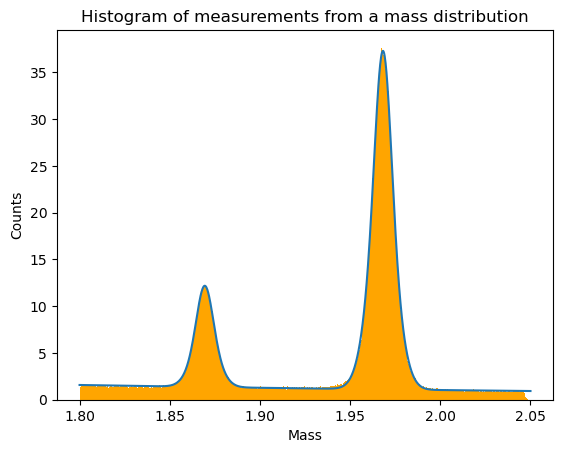

In [27]:
# Plotting
x = np.linspace(xmass_min, xmass_max, 1000)
y = composite_pdf_summed(x, mu_1 = minuit.values["mu_1"], sigma_1 = minuit.values["sigma_1"], mu_2 = minuit.values["mu_2"], sigma_2 = minuit.values["sigma_2"], mu_3 = minuit.values["mu_3"], sigma_3 = minuit.values["sigma_3"], mu_4 = minuit.values["mu_4"], sigma_4 = minuit.values["sigma_4"], tau = minuit.values["tau"], f = minuit.values["f"],f_1 = minuit.values["f_1"])

# Plotting as histogram to see the range of data
counts = plt.hist(xmass, bins = n_bins, color='orange', density=True)
plt.plot(x, y)
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

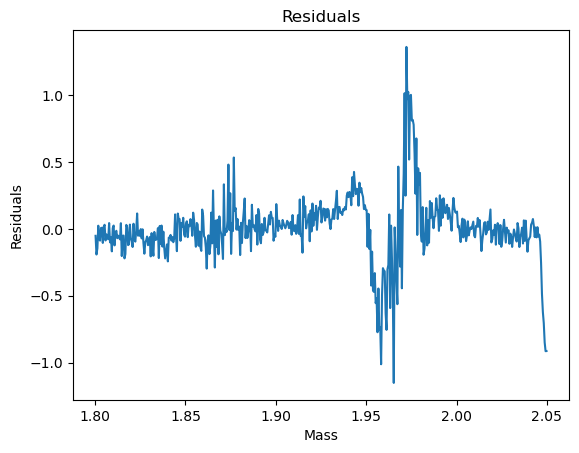

In [28]:
#resituals plot 

x = np.linspace(1.8+0.00025,2.05-0.00025,500)

y = composite_pdf_summed(x, mu_1 = minuit.values["mu_1"], sigma_1 = minuit.values["sigma_1"], mu_2 = minuit.values["mu_2"], sigma_2 = minuit.values["sigma_2"], mu_3 = minuit.values["mu_3"], sigma_3 = minuit.values["sigma_3"], mu_4 = minuit.values["mu_4"], sigma_4 = minuit.values["sigma_4"], tau = minuit.values["tau"], f = minuit.values["f"],f_1 = minuit.values["f_1"])
y = np.array(y)

residual = np.subtract(counts[0],y)

plt.plot(x,residual)
plt.title('Residuals')
plt.ylabel('Residuals')
plt.xlabel('Mass')
plt.show()


In [29]:
def crystal_ball(x,beta,m, mu , sigma):
    #mean, var, skew, kurt = crystalball.stats(beta, m, moments='mvsk')
    crystal = crystalball.pdf(x, beta, m, mu , sigma)
    return crystal
#print(crystal_ball(3,2,1.2,1.8,0.5))

def composite_pdf_crystal(x, tau, f_1,f_2,mu_1 , sigma_1,mu_2 , sigma_2):
    beta_1 = 2
    beta_2 = 2
    m_2 = 1.1
    m_1 = 1.1
    
    return ( (f_1)*crystal_ball(x, beta_1, m_1,mu_1,sigma_1) + (f_2)*crystal_ball(x, beta_2, m_2,mu_2,sigma_2) + (1-(f_2+f_1))*norm_exp(x, tau))

In [30]:
# set guesses for minuit
tau_guess = 0.5
f_1_guess = 0.15
f_2_guess = 0.54
mu_1_guess = 1.87
mu_2_guess = 1.97
sigma_1_guess = 0.0056
sigma_2_guess = 0.006

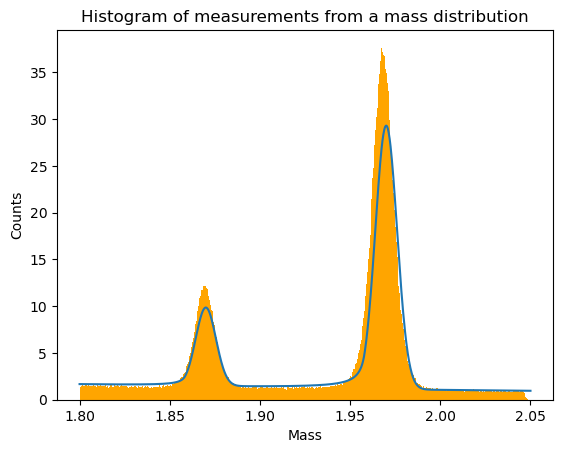

In [31]:
n_bins = 500
# Plotting
x = np.linspace(xmass_min, xmass_max, 1000)
y = composite_pdf_crystal(x,tau = tau_guess, f_1 = f_1_guess, f_2 = f_2_guess,mu_1=mu_1_guess ,
                          sigma_1=sigma_1_guess,mu_2 =mu_2_guess  , sigma_2=sigma_2_guess)
#print(y)
#print(x)
# Plotting as histogram to see the range of data
plt.hist(xmass, bins = n_bins , color='orange',density=True)
plt.plot(x, y)
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

In [32]:
nll = UnbinnedNLL(xmass, composite_pdf_crystal)
# set params to some vals
minuit = Minuit(nll,tau = tau_guess, f_1 = f_1_guess, f_2 = f_2_guess,mu_1=mu_1_guess ,
                          sigma_1=sigma_1_guess,mu_2 =mu_2_guess  , sigma_2=sigma_2_guess)
minuit.errordef = 0.5
minuit.errors = [0.001, 0.001, 0.001, 0.001,0.001,0.001,0.001]
minuit.limits["f_1"] = (0, 1)
minuit.limits["f_2"] = (0, 1)
minuit.limits["mu_1"] = (1.84, 1.9)
minuit.limits["mu_2"] = (1.94, 2)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")

tau = 0.6456036137011044 +/- 0.01224336902432241
f_1 = 0.13907299910749138 +/- 0.00047053715862196976
f_2 = 0.5512748728842586 +/- 0.0006303351052888706
mu_1 = 1.8695043227151615 +/- 1.9428056883152856e-05
sigma_1 = 0.004996286280998769 +/- 1.7263723736216872e-05
mu_2 = 1.9682338409872184 +/- 9.87043529232512e-06
sigma_2 = 0.005880768775623285 +/- 8.589494120494087e-06


In [33]:
#create a function for the NLL (for test)
def nll(mass,tau,f_1,f_2,mu_1,sigma_1,mu_2,sigma_2):
    array = [] 
    for i in range(len(mass)):
        nll_1 = np.log(composite_pdf_crystal(mass[i], tau,f_1,f_2,mu_1,sigma_1,mu_2,sigma_2) )
        array.append(nll_1)
    nll = -np.sum(array)
    
    return nll

print("nll value for crystal ball:",nll(mass = xmass,tau = minuit.values["tau"], f_1 = minuit.values["f_1"],f_2=minuit.values["f_2"],mu_1=minuit.values["mu_1"] , sigma_1=minuit.values["sigma_1"],mu_2=minuit.values["mu_2"] , sigma_2=minuit.values["sigma_2"]))

nll value for crystal ball: -942781.239273227


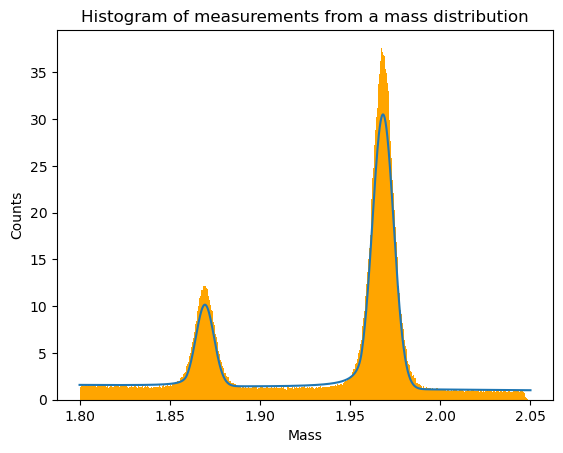

In [34]:
# Plotting
x = np.linspace(xmass_min, xmass_max, 1000)
y = composite_pdf_crystal(x, tau = minuit.values["tau"], f_1 = minuit.values["f_1"],f_2=minuit.values["f_2"],mu_1=minuit.values["mu_1"] , sigma_1=minuit.values["sigma_1"],mu_2=minuit.values["mu_2"] , sigma_2=minuit.values["sigma_2"])
#y = composite_pdf_2(x, mu = minuit.values["mu"], sigma = minuit.values["sigma"], mu_2 = minuit.values["mu_2"], sigma_2 = minuit.values["sigma_2"],tau = minuit.values["tau"], f = minuit.values["f"],f_2 = minuit.values["f_2"])

# Plotting as histogram to see the range of data
counts = plt.hist(xmass, bins = n_bins, color='orange',density=True)
plt.plot(x, y)
plt.title("Histogram of measurements from a mass distribution")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

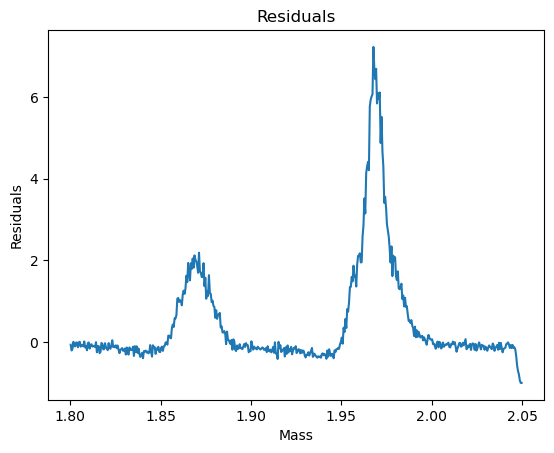

In [35]:
#resituals plot 

x = np.linspace(1.8+0.00025,2.05-0.00025,500)

y = composite_pdf_crystal(x, tau = minuit.values["tau"], f_1 = minuit.values["f_1"],f_2=minuit.values["f_2"],mu_1=minuit.values["mu_1"] , sigma_1=minuit.values["sigma_1"],mu_2=minuit.values["mu_2"] , sigma_2=minuit.values["sigma_2"])
y = np.array(y)

residual = np.subtract(counts[0],y)

plt.plot(x,residual)
plt.title('Residuals')
plt.ylabel('Residuals')
plt.xlabel('Mass')
plt.show()


### • Read the publication and see what is said about systematic errors. Make a rea- sonable attempt at determining some systematic errors on the masses.

1) we determine the systematic uncertainties of our fit via the shift method. We have 3 models. We take the largest shift in mean value between the models and this is our systematic error.<br>

2) other uncertainties which we must include which are due to experiment and not fitting. find from mathews paper lol <br>

### • Study how the mass and the width of the peak (the resolution) depends on the transverse momentum (p⊥) and rapidity (η).<br>

In [162]:
#first i split mass regions by momentum

#split mass into mometum regions


f = open("kkp.bin","r")
b = np.fromfile(f,dtype=np.float32)
ncol = 7
# number of events
nevent = len(b)/ncol
xdata = np.split(b, nevent, axis=0)
#print(xdata[0])

momentum = []
for i in range(0, len(xdata)):
    momentum.append((xdata[i][2])/1000)
    #if i < 100:
        #print(momentum[i])
        
#print(np.mean(momentum))        
       
print(np.max(momentum))
        
print(np.min(momentum))

diff = np.max(momentum)-np.min(momentum)
#print(diff*(1/4))
#print(np.min(momentum) + diff*(1/4))

momentum_ind_1 = []
momentum_ind_2 = []
momentum_ind_3 = []
momentum_ind_4 = []

for i in range(0, len(xdata)):
      
    if momentum[i] < (2):
        momentum_ind_1.append(i)
        #print(i)
        #print(i)

    if momentum[i] > (2) and  momentum[i] < (5):
        momentum_ind_2.append(i)

    if momentum[i] > (5) and momentum[i] < (10):
        momentum_ind_3.append(i)
        
    if momentum[i] > (10):
        momentum_ind_4.append(i)
        
    else:
        pass

    
print(len(momentum_ind_1))
print(len(momentum_ind_2))
print(len(momentum_ind_3))
print(len(momentum_ind_4))


xmass = []
for i in range(0, len(xdata)):
    xmass.append((xdata[i][0])/1000)
    #if i < 10:
    #print(xmass[i])
    
mass_1 = []        
for index in momentum_ind_1:
    mass_1.append(xmass[index])

mass_2 = []        
for index in momentum_ind_2:
    mass_2.append(xmass[index])
    
    
mass_3 = []        
for index in momentum_ind_3:
    mass_3.append(xmass[index])
    
mass_4 = []        
for index in momentum_ind_4:
    mass_4.append(xmass[index])

44.64885546875
0.7557097778320313
36631
262479
137323
17136


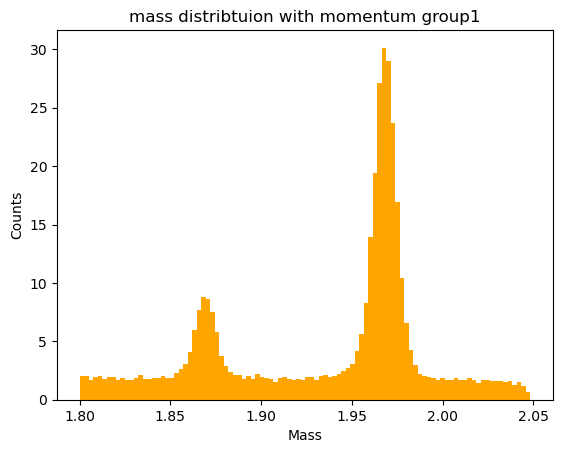

In [163]:
#plot his of each region just to see

counts = plt.hist(mass_1, bins = 100, color='orange',density=True)
plt.title("mass distribtuion with momentum group1")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

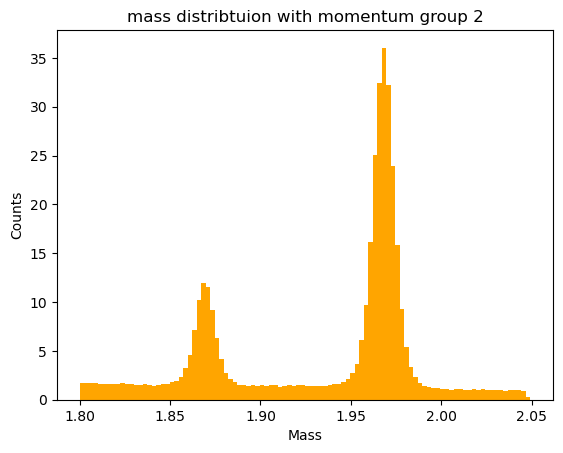

In [164]:
counts = plt.hist(mass_2, bins = 100, color='orange',density=True)
plt.title("mass distribtuion with momentum group 2")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

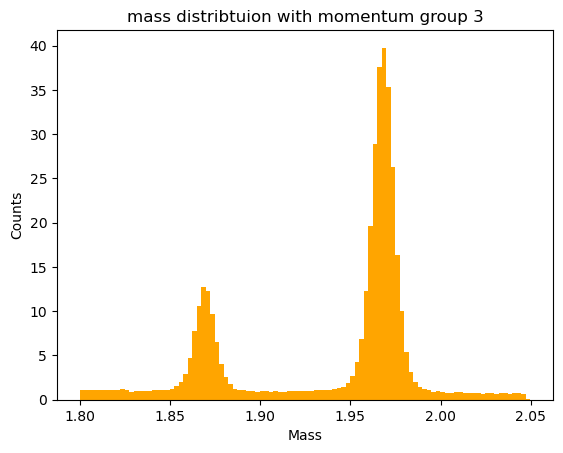

In [165]:
counts = plt.hist(mass_3, bins = 100, color='orange',density=True)
plt.title("mass distribtuion with momentum group 3")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

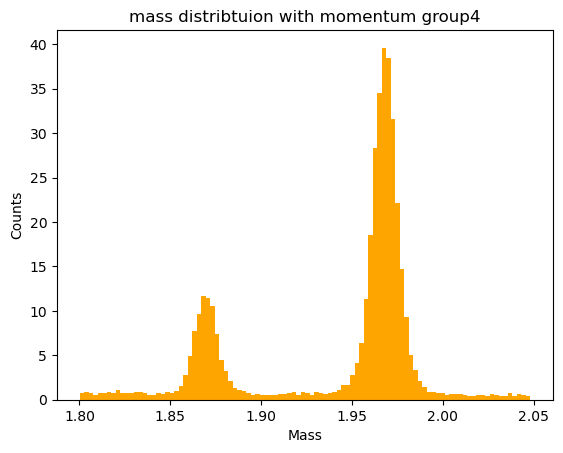

In [166]:
counts = plt.hist(mass_4, bins = 100, color='orange',density=True)
plt.title("mass distribtuion with momentum group4")
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

In [180]:
#now we do a seperate fit for all 4 regions - with gaussian and exponential as our fit model

#region 1

nll = UnbinnedNLL(mass_1, composite_pdf_2)
# set params to some vals
minuit = Minuit(nll, mu = mu_guess, sigma = sigma_guess, mu_2 = mu_2_guess, sigma_2 = sigma_2_guess, tau = tau_guess, f = f_guess, f_2 = f_2_guess)
minuit.errordef = 0.5
minuit.errors = [0.1, 0.001, 0.1, 0.001,0.1,0.1,0.1]
minuit.limits["f"] = (0, 1)
minuit.limits["f_2"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")
    
mu_region_1 = minuit.values["mu"]
mu_2_region_1 = minuit.values["mu_2"]
sigma_region_1 = minuit.values["sigma"]
sigma_2_region_1 = minuit.values["sigma_2"]

e_mu_region_1 = minuit.errors["mu"]
e_mu_2_region_1 = minuit.errors["mu_2"]
e_sigma_region_1 = minuit.errors["sigma"]
e_sigma_2_region_1 = minuit.errors["sigma_2"]

mu = 1.8693007390218377 +/- 9.753803187904522e-05
sigma = 0.005809603433287161 +/- 9.366107464802055e-05
mu_2 = 1.9681855897625782 +/- 4.2085943425309155e-05
sigma_2 = 0.006480075802968303 +/- 3.794777035128939e-05
tau = 1.0750181794341551 +/- 0.0953167973402571
f = 0.10158508309972536 +/- 0.0015361251489044436
f_2 = 0.44674360425125614 +/- 0.002160800113394784


In [181]:
#region 2

nll = UnbinnedNLL(mass_2, composite_pdf_2)
# set params to some vals
minuit = Minuit(nll, mu = mu_guess, sigma = sigma_guess, mu_2 = mu_2_guess, sigma_2 = sigma_2_guess, tau = tau_guess, f = f_guess, f_2 = f_2_guess)
minuit.errordef = 0.5
minuit.errors = [0.1, 0.001, 0.1, 0.001,0.1,0.1,0.1]
minuit.limits["f"] = (0, 1)
minuit.limits["f_2"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")

    
mu_region_2 = minuit.values["mu"]
mu_2_region_2 = minuit.values["mu_2"]
sigma_region_2 = minuit.values["sigma"]
sigma_2_region_2 = minuit.values["sigma_2"]

    
e_mu_region_2 = minuit.errors["mu"]
e_mu_2_region_2 = minuit.errors["mu_2"]
e_sigma_region_2 = minuit.errors["sigma"]
e_sigma_2_region_2 = minuit.errors["sigma_2"]

mu = 1.869418241209359 +/- 2.654298271893882e-05
sigma = 0.005575187053321684 +/- 2.4682582480333608e-05
mu_2 = 1.9680977707854426 +/- 1.3469035515830822e-05
sigma_2 = 0.006213350562972424 +/- 1.1744939538973376e-05
tau = 0.43733507272637195 +/- 0.006807868042556104
f = 0.14299697007769885 +/- 0.0005985026048342668
f_2 = 0.512630833941892 +/- 0.000777695551606894


In [185]:
#region 3

nll = UnbinnedNLL(mass_3, composite_pdf_2)
# set params to some vals
minuit = Minuit(nll, mu = mu_guess, sigma = sigma_guess, mu_2 = mu_2_guess, sigma_2 = sigma_2_guess, tau = tau_guess, f = f_guess, f_2 = f_2_guess)
minuit.errordef = 0.5
minuit.errors = [0.1, 0.001, 0.1, 0.001,0.1,0.1,0.1]
minuit.limits["f"] = (0, 1)
minuit.limits["f_2"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")

mu_region_3 = minuit.values["mu"]
mu_2_region_3 = minuit.values["mu_2"]
sigma_region_3 = minuit.values["sigma"]
sigma_2_region_3 = minuit.values["sigma_2"]

e_mu_region_3 = minuit.errors["mu"]
e_mu_2_region_3 = minuit.errors["mu_2"]
e_sigma_region_3 = minuit.errors["sigma"]
e_sigma_2_region_3 = minuit.errors["sigma_2"]

mu = 1.8695023884071682 +/- 3.2541814608308894e-05
sigma = 0.005649279401170559 +/- 2.902343290575929e-05
mu_2 = 1.9680749126904942 +/- 1.721404501474373e-05
sigma_2 = 0.006358675464769158 +/- 1.4539175861619894e-05
tau = 0.5974942111833516 +/- 0.02084101005527886
f = 0.16266605157451808 +/- 0.0008164655871753801
f_2 = 0.5932733414102431 +/- 0.0010343549055931156


In [186]:
#region 4

nll = UnbinnedNLL(mass_4, composite_pdf_2)
# set params to some vals
minuit = Minuit(nll, mu = mu_guess, sigma = sigma_guess, mu_2 = mu_2_guess, sigma_2 = sigma_2_guess, tau = tau_guess, f = f_guess, f_2 = f_2_guess)
minuit.errordef = 0.5
minuit.errors = [0.1, 0.001, 0.1, 0.001,0.1,0.1,0.1]
minuit.limits["f"] = (0, 1)
minuit.limits["f_2"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")

    
mu_region_4 = minuit.values["mu"]
mu_2_region_4 = minuit.values["mu_2"]
sigma_region_4 = minuit.values["sigma"]
sigma_2_region_4 = minuit.values["sigma_2"]

e_mu_region_4 = minuit.errors["mu"]
e_mu_2_region_4 = minuit.errors["mu_2"]
e_sigma_region_4 = minuit.errors["sigma"]
e_sigma_2_region_4 = minuit.errors["sigma_2"]

mu = 1.869709991899951 +/- 9.54939675980641e-05
sigma = 0.006287416187402312 +/- 8.242713819823568e-05
mu_2 = 1.9682196329427175 +/- 5.063770192374358e-05
sigma_2 = 0.00703567088878725 +/- 4.2454220214157704e-05
tau = 0.8437646183856203 +/- 0.1412324765474236
f = 0.17367173229794908 +/- 0.0022966060538698874
f_2 = 0.6535785164380475 +/- 0.002821023488687624


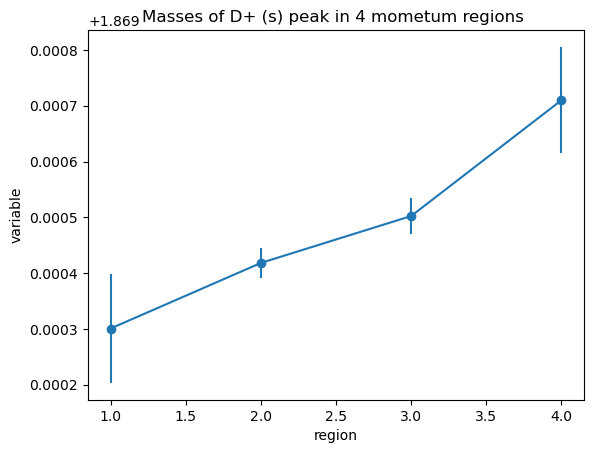

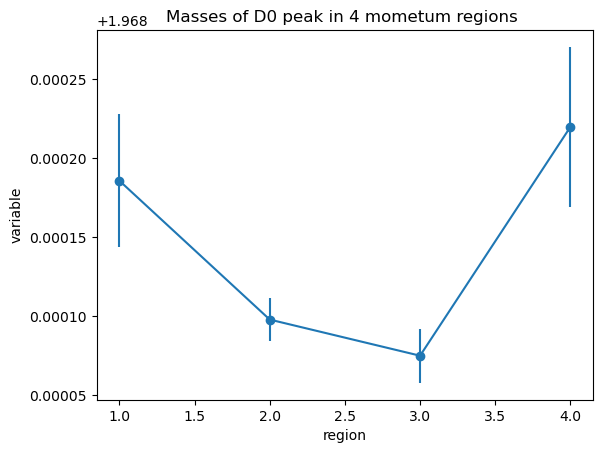

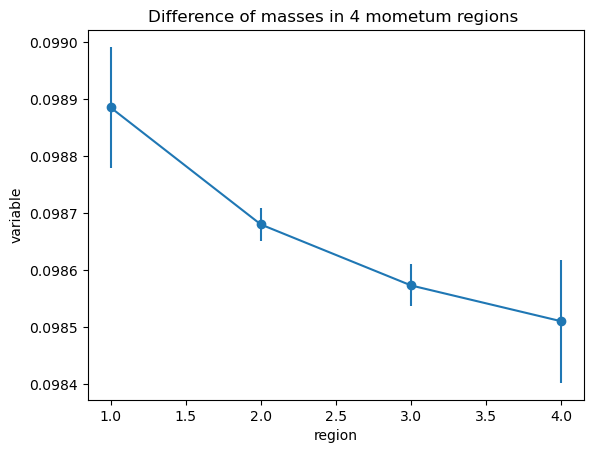

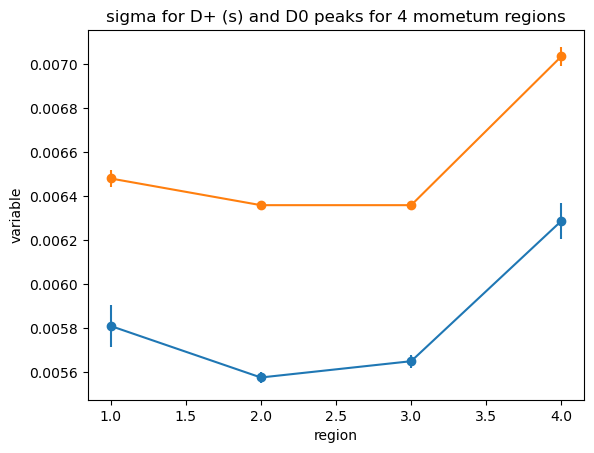

In [188]:
#make plot of region vs mass, difference in mass and sigma

x = [1,2,3,4]

y1 = [mu_region_1,mu_region_2,mu_region_3,mu_region_4]
y2 = [mu_2_region_1,mu_2_region_2,mu_2_region_3,mu_2_region_4]
y3 = [sigma_region_1 ,sigma_region_2 ,sigma_region_3 ,sigma_region_4 ]
y4 = [sigma_2_region_1,sigma_2_region_3,sigma_2_region_3, sigma_2_region_4]

ey1 = [e_mu_region_1,e_mu_region_2,e_mu_region_3,e_mu_region_4]
ey2 = [e_mu_2_region_1,e_mu_2_region_2,e_mu_2_region_3,e_mu_2_region_4]
ey3 = [e_sigma_region_1 ,e_sigma_region_2 ,e_sigma_region_3 ,e_sigma_region_4 ]
ey4 = [e_sigma_2_region_1,e_sigma_2_region_3,e_sigma_2_region_3, e_sigma_2_region_4]


plt.errorbar(x, y1, yerr=ey1,marker ='o')
plt.title('Masses of D+ (s) peak in 4 mometum regions ')
plt.ylabel('variable')
plt.xlabel('region')
plt.show()


plt.errorbar(x, y2, yerr=ey2,marker ='o')
plt.title('Masses of D0 peak in 4 mometum regions ')
plt.ylabel('variable')
plt.xlabel('region')
plt.show()

diff = np.subtract(y2,y1)
ediff = np.sqrt(np.square(ey1)+np.square(ey2))
plt.errorbar(x, diff, yerr=ediff,marker ='o')
plt.title('Difference of masses in 4 mometum regions ')
plt.ylabel('variable')
plt.xlabel('region')
plt.show()

plt.errorbar(x, y3, yerr=ey3,marker ='o')
plt.errorbar(x, y4, yerr=ey4,marker ='o')
plt.title('sigma for D+ (s) and D0 peaks for 4 mometum regions')
plt.ylabel('variable')
plt.xlabel('region')
plt.show()

In [145]:
#now i split mass regions by rapidity

#split mass into mometum regions


f = open("kkp.bin","r")
b = np.fromfile(f,dtype=np.float32)
ncol = 7
# number of events
nevent = len(b)/ncol
xdata = np.split(b, nevent, axis=0)
#print(xdata[0])

rap = []
for i in range(0, len(xdata)):
    rap.append((xdata[i][3]))
    #if i < 100:
        #print(momentum[i])
        
#print(np.mean(momentum))        
       
print(np.max(rap))
        
print(np.min(rap))

diff = np.max(rap)-np.min(rap)
#print(diff*(1/4))
#print(np.min(momentum) + diff*(1/4))

rap_ind_1 = []
rap_ind_2 = []
rap_ind_3 = []
rap_ind_4 = []

for i in range(0, len(xdata)):
      
    if rap[i] < (2.675):
        rap_ind_1.append(i)
        #print(i)
        #print(i)

    if rap[i] > (2.675) and  rap[i] < (3.55):
        rap_ind_2.append(i)

    if rap[i] > (3.55) and rap[i] < (4.425):
        rap_ind_3.append(i)
        
    if rap[i] > (4.425):
        rap_ind_4.append(i)
        
    else:
        pass

    
print(len(rap_ind_1))
print(len(rap_ind_2))
print(len(rap_ind_3))
print(len(rap_ind_4))


xmass = []
for i in range(0, len(xdata)):
    xmass.append((xdata[i][0])/1000)
    #if i < 10:
    #print(xmass[i])
    
mass_1 = []        
for index in rap_ind_1:
    mass_1.append(xmass[index])

mass_2 = []        
for index in rap_ind_2:
    mass_2.append(xmass[index])
    
    
mass_3 = []        
for index in rap_ind_3:
    mass_3.append(xmass[index])
    
mass_4 = []        
for index in rap_ind_4:
    mass_4.append(xmass[index])

5.313434
1.8134989
60883
259274
128853
4559


In [146]:
#now we do a seperate fit for all 4 regions - with gaussian and exponential as our fit model

#region 1

nll = UnbinnedNLL(mass_1, composite_pdf_2)
# set params to some vals
minuit = Minuit(nll, mu = mu_guess, sigma = sigma_guess, mu_2 = mu_2_guess, sigma_2 = sigma_2_guess, tau = tau_guess, f = f_guess, f_2 = f_2_guess)
minuit.errordef = 0.5
minuit.errors = [0.1, 0.001, 0.1, 0.001,0.1,0.1,0.1]
minuit.limits["f"] = (0, 1)
minuit.limits["f_2"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")
    
mu_region_1 = minuit.values["mu"]
mu_2_region_1 = minuit.values["mu_2"]
sigma_region_1 = minuit.values["sigma"]
sigma_2_region_1 = minuit.values["sigma_2"]

C:\Users\unaal\OneDrive\Documents\Python\envs\daml-environment\lib\site-packages\iminuit\cost.py:72: RuntimeWarning: invalid value encountered in log
  return np.log(x + 1e-323)


mu = 1.869453571851308 +/- 4.220295913781202e-05
sigma = 0.00495258825597294 +/- 3.795207360459498e-05
mu_2 = 1.9680749844787753 +/- 2.2456065412488316e-05
sigma_2 = 0.005388903478009343 +/- 1.8593109095339536e-05
tau = -632522.3646870363 +/- 4701272.95329258
f = 0.16394875248299795 +/- 0.0012033162566804645
f_2 = 0.5657770119038545 +/- 0.0015491450011173025


In [147]:
#region 2

nll = UnbinnedNLL(mass_2, composite_pdf_2)
# set params to some vals
minuit = Minuit(nll, mu = mu_guess, sigma = sigma_guess, mu_2 = mu_2_guess, sigma_2 = sigma_2_guess, tau = tau_guess, f = f_guess, f_2 = f_2_guess)
minuit.errordef = 0.5
minuit.errors = [0.1, 0.001, 0.1, 0.001,0.1,0.1,0.1]
minuit.limits["f"] = (0, 1)
minuit.limits["f_2"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")

    
mu_region_2 = minuit.values["mu"]
mu_2_region_2 = minuit.values["mu_2"]
sigma_region_2 = minuit.values["sigma"]
sigma_2_region_2 = minuit.values["sigma_2"]

mu = 1.8694218135245766 +/- 2.4857855144981773e-05
sigma = 0.0054663672870134215 +/- 2.260086694737757e-05
mu_2 = 1.9680718208022487 +/- 1.269162181836595e-05
sigma_2 = 0.006083091024695516 +/- 1.0843716890422382e-05
tau = 0.45443835141853606 +/- 0.007819240592145008
f = 0.14959073052481536 +/- 0.0005952584625265045
f_2 = 0.5440783437692731 +/- 0.0007693979509770799


In [148]:
#region 3

nll = UnbinnedNLL(mass_3, composite_pdf_2)
# set params to some vals
minuit = Minuit(nll, mu = mu_guess, sigma = sigma_guess, mu_2 = mu_2_guess, sigma_2 = sigma_2_guess, tau = tau_guess, f = f_guess, f_2 = f_2_guess)
minuit.errordef = 0.5
minuit.errors = [0.1, 0.001, 0.1, 0.001,0.1,0.1,0.1]
minuit.limits["f"] = (0, 1)
minuit.limits["f_2"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")

mu_region_3 = minuit.values["mu"]
mu_2_region_3 = minuit.values["mu_2"]
sigma_region_3 = minuit.values["sigma"]
sigma_2_region_3 = minuit.values["sigma_2"]

mu = 1.8694812050142622 +/- 4.647370142166763e-05
sigma = 0.0065695099110861755 +/- 4.336144004719861e-05
mu_2 = 1.9681738534877593 +/- 2.2791732976570636e-05
sigma_2 = 0.007271081240091666 +/- 1.9958272819947912e-05
tau = 0.6760642553367592 +/- 0.023266276225802768
f = 0.13873490534229532 +/- 0.0008734714056663762
f_2 = 0.5132951110389443 +/- 0.0011383591131773896


In [149]:
#region 4

nll = UnbinnedNLL(mass_4, composite_pdf_2)
# set params to some vals
minuit = Minuit(nll, mu = mu_guess, sigma = sigma_guess, mu_2 = mu_2_guess, sigma_2 = sigma_2_guess, tau = tau_guess, f = f_guess, f_2 = f_2_guess)
minuit.errordef = 0.5
minuit.errors = [0.1, 0.001, 0.1, 0.001,0.1,0.1,0.1]
minuit.limits["f"] = (0, 1)
minuit.limits["f_2"] = (0, 1)
minuit.migrad()
minuit.hesse()

for i, j, k in zip(minuit.parameters, minuit.values, minuit.errors):
    print(f"{i} = {j} +/- {k}")

    
mu_region_4 = minuit.values["mu"]
mu_2_region_4 = minuit.values["mu_2"]
sigma_region_4 = minuit.values["sigma"]
sigma_2_region_4 = minuit.values["sigma_2"]

mu = 1.8692381785707994 +/- 0.00044895072529458664
sigma = 0.008660010007891426 +/- 0.0004162901380603866
mu_2 = 1.9683043585730213 +/- 0.00016899728320342083
sigma_2 = 0.009198466705426185 +/- 0.00015916317329077383
tau = 82721.65773336496 +/- 1.414212148161654
f = 0.09748041354306025 +/- 0.004603480712706359
f_2 = 0.4755830241455159 +/- 0.006550893500302302


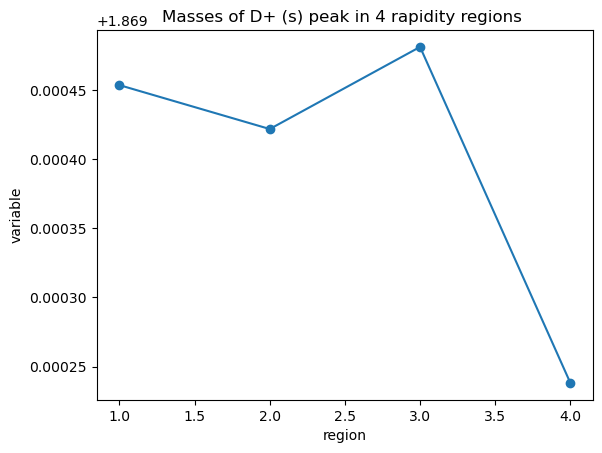

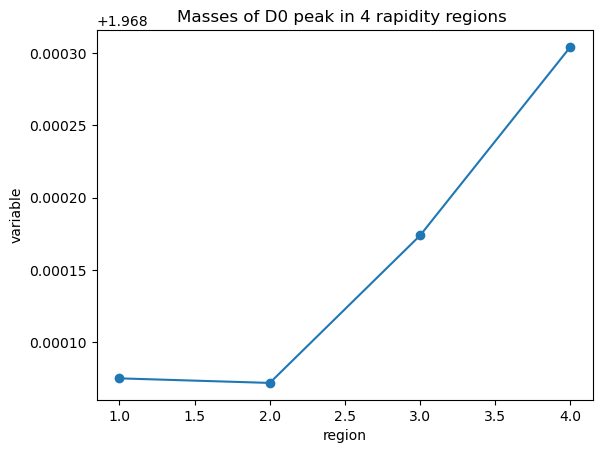

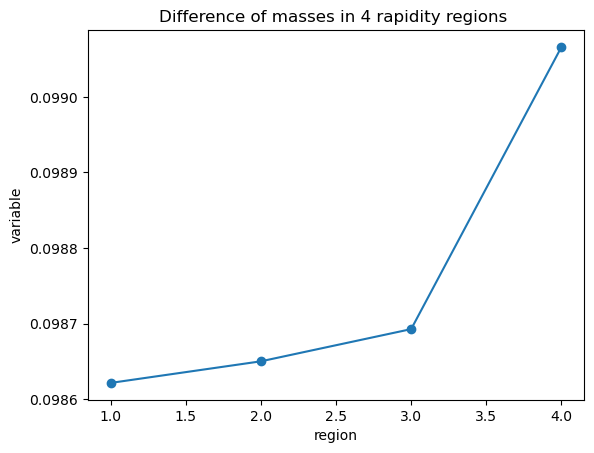

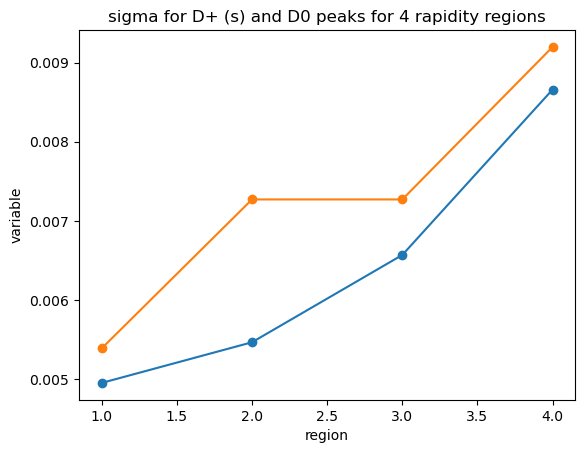

In [151]:
#make plot of region vs mass, difference in mass and sigma

x = [1,2,3,4]
y1 = [mu_region_1,mu_region_2,mu_region_3,mu_region_4]
y2 = [mu_2_region_1,mu_2_region_2,mu_2_region_3,mu_2_region_4]
y3 = [sigma_region_1 ,sigma_region_2 ,sigma_region_3 ,sigma_region_4 ]
y4 = [sigma_2_region_1,sigma_2_region_3,sigma_2_region_3, sigma_2_region_4]

plt.plot(x,y1,marker ='o')
plt.title('Masses of D+ (s) peak in 4 rapidity regions ')
plt.ylabel('variable')
plt.xlabel('region')
plt.show()


plt.plot(x,y2,marker ='o')
plt.title('Masses of D0 peak in 4 rapidity regions ')
plt.ylabel('variable')
plt.xlabel('region')
plt.show()

diff = np.subtract(y2,y1)
plt.plot(x,diff,marker ='o')
plt.title('Difference of masses in 4 rapidity regions ')
plt.ylabel('variable')
plt.xlabel('region')
plt.show()


plt.plot(x,y3,marker ='o')
plt.plot(x,y4,marker ='o')
plt.title('sigma for D+ (s) and D0 peaks for 4 rapidity regions')
plt.ylabel('variable')
plt.xlabel('region')
plt.show()

### Questions and answers

- Q: Our systematic uncertainy from the model will by the same for every method because we take the biggest difference?

    A: yes, sys error for each measurment will be the same. they have made selection for us already. so we fit all models first and then take diff. if something is not a good fit dont include - decide by nll



- Q: for multiple systematic errors do we add them in quadrature to get one total systematic error (systematic error from detector plus the fit)??

    A: in paper they quote all errors seperatley even the sys errors<br>, but also state the overall systematic error (quadrature)

- Q: can we take an average of all 3 fits for actual mass value ? or do we take the one with best fit? can best fit be described as lowest nll value, or is that not accurate?<br>
    A: lowest nll gives best model

- Q: why are interested in the mass difference

    A: cancel systematic from momentum scale
    so if the difference between Q is bigger than the systematic error - bad

    it gives a shift that the mass data needs to be shifted by

    thats why they quite the difference in masses
    cancelling the systematic error due to momentum scale if we take the difference



#### precsion and accuracy discussion:

systematic error:
influences accruacy
higher error, lower accuracy
does not influence precision

stat error:
influence precision
higher errr, lower prescision
does not influence accuracy


when we do next part<br>

if our means dont agree, then we have issue with accuracy-> systematic error<br>
mean should agree <br>


if our sigma dont agree, then we have issue with prescision -> this is problem with detector-> measured worse with higher pt

1) mean should NOT depend on the transverse momemntum/rapidity

2) spread can depend on the  transverse momemntum/rapidity




## THERE ARE SEVEN OBSERVABLES:

• invariant mass of K+K−π+ candidate in MeV/c2

• invariant mass of kaon pair in MeV/c2

• transverse momentum of K+K−π+ candidate in GeV/c

• rapidity η of K+K−π+ candidate

• minimum tranverse momentum of the three tracks in the K+K−π+ candidate

• electric charge of the candidate

• polarity of the LHCb magnetic field


## WHAT WE CAN DO:


Model: Gaussian + Crystal Ball ?????


take rapidity for example

1) seperate the data into sections of low/medium/high rapidity

2)fit mean and spread for each section of data

3)compare the means and spread on a graph to 

4) mean should stay the same and spread can be different. eg. for higher moment we are less accurate

If we see a trend in the  rapidity and momentum plots there is something wrong with the detector as the mass shouldn't depend on momentum or pseudorapidity. 



### Additional (we are not doin this now)
plot 4 different plots:
• + electric charge and + polarity

• + electric charge and - polarity

• - electric charge and + polarity

• - electric charge and - polarity


Obtained mass should be the same for all 4 plots -> if not there are some errors.

- Q: what are the systematic uncertainties due to calibration of the momentum scale of the the detector? are they related to the momentum resolution of the tracker  or the transverse momenta/pseudorapidity region?
    A: they shoot J/psi I think? theat they know the mass of and take the shift measured in mass to calibrate the detector


3.6.4 Project planning<br>
The project descriptions are generally significantly less detailed than what was made avail-
able for the checkpoints. Any material covered during checkpoints including python code
examples are assumed to be known. Only essential and new information is provided and you
are expected to take care of the details. Python code snippets are provided where necessary,
but you will have to understand yourself what they do. It is recommend that you google for
information about your project on the web, including data sheets of components and python
libraries, if applicable. Python scripts should be well structured, either using functions or
classes.<br>
The timeline will vary between different projects, but in general, it is recommended that you
plan your work as follows:<br>
• weeks 7, 8 & 9: Building your gadget and/or writing code for project;<br>
• week 9, 10: Analysis of data or equivalent, prepare supplementary material;<br>
• week 10, 11: Finish writing of project report and prepare submission.<br>
Note that you are advised to start writing your report as the project progresses.
For guidance on report writing, how the projects will be assessed, plagiarism and the sub-
mission deadline, please consult the DAH course booklet and the DAH grade descriptors,
available on Learn.